The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


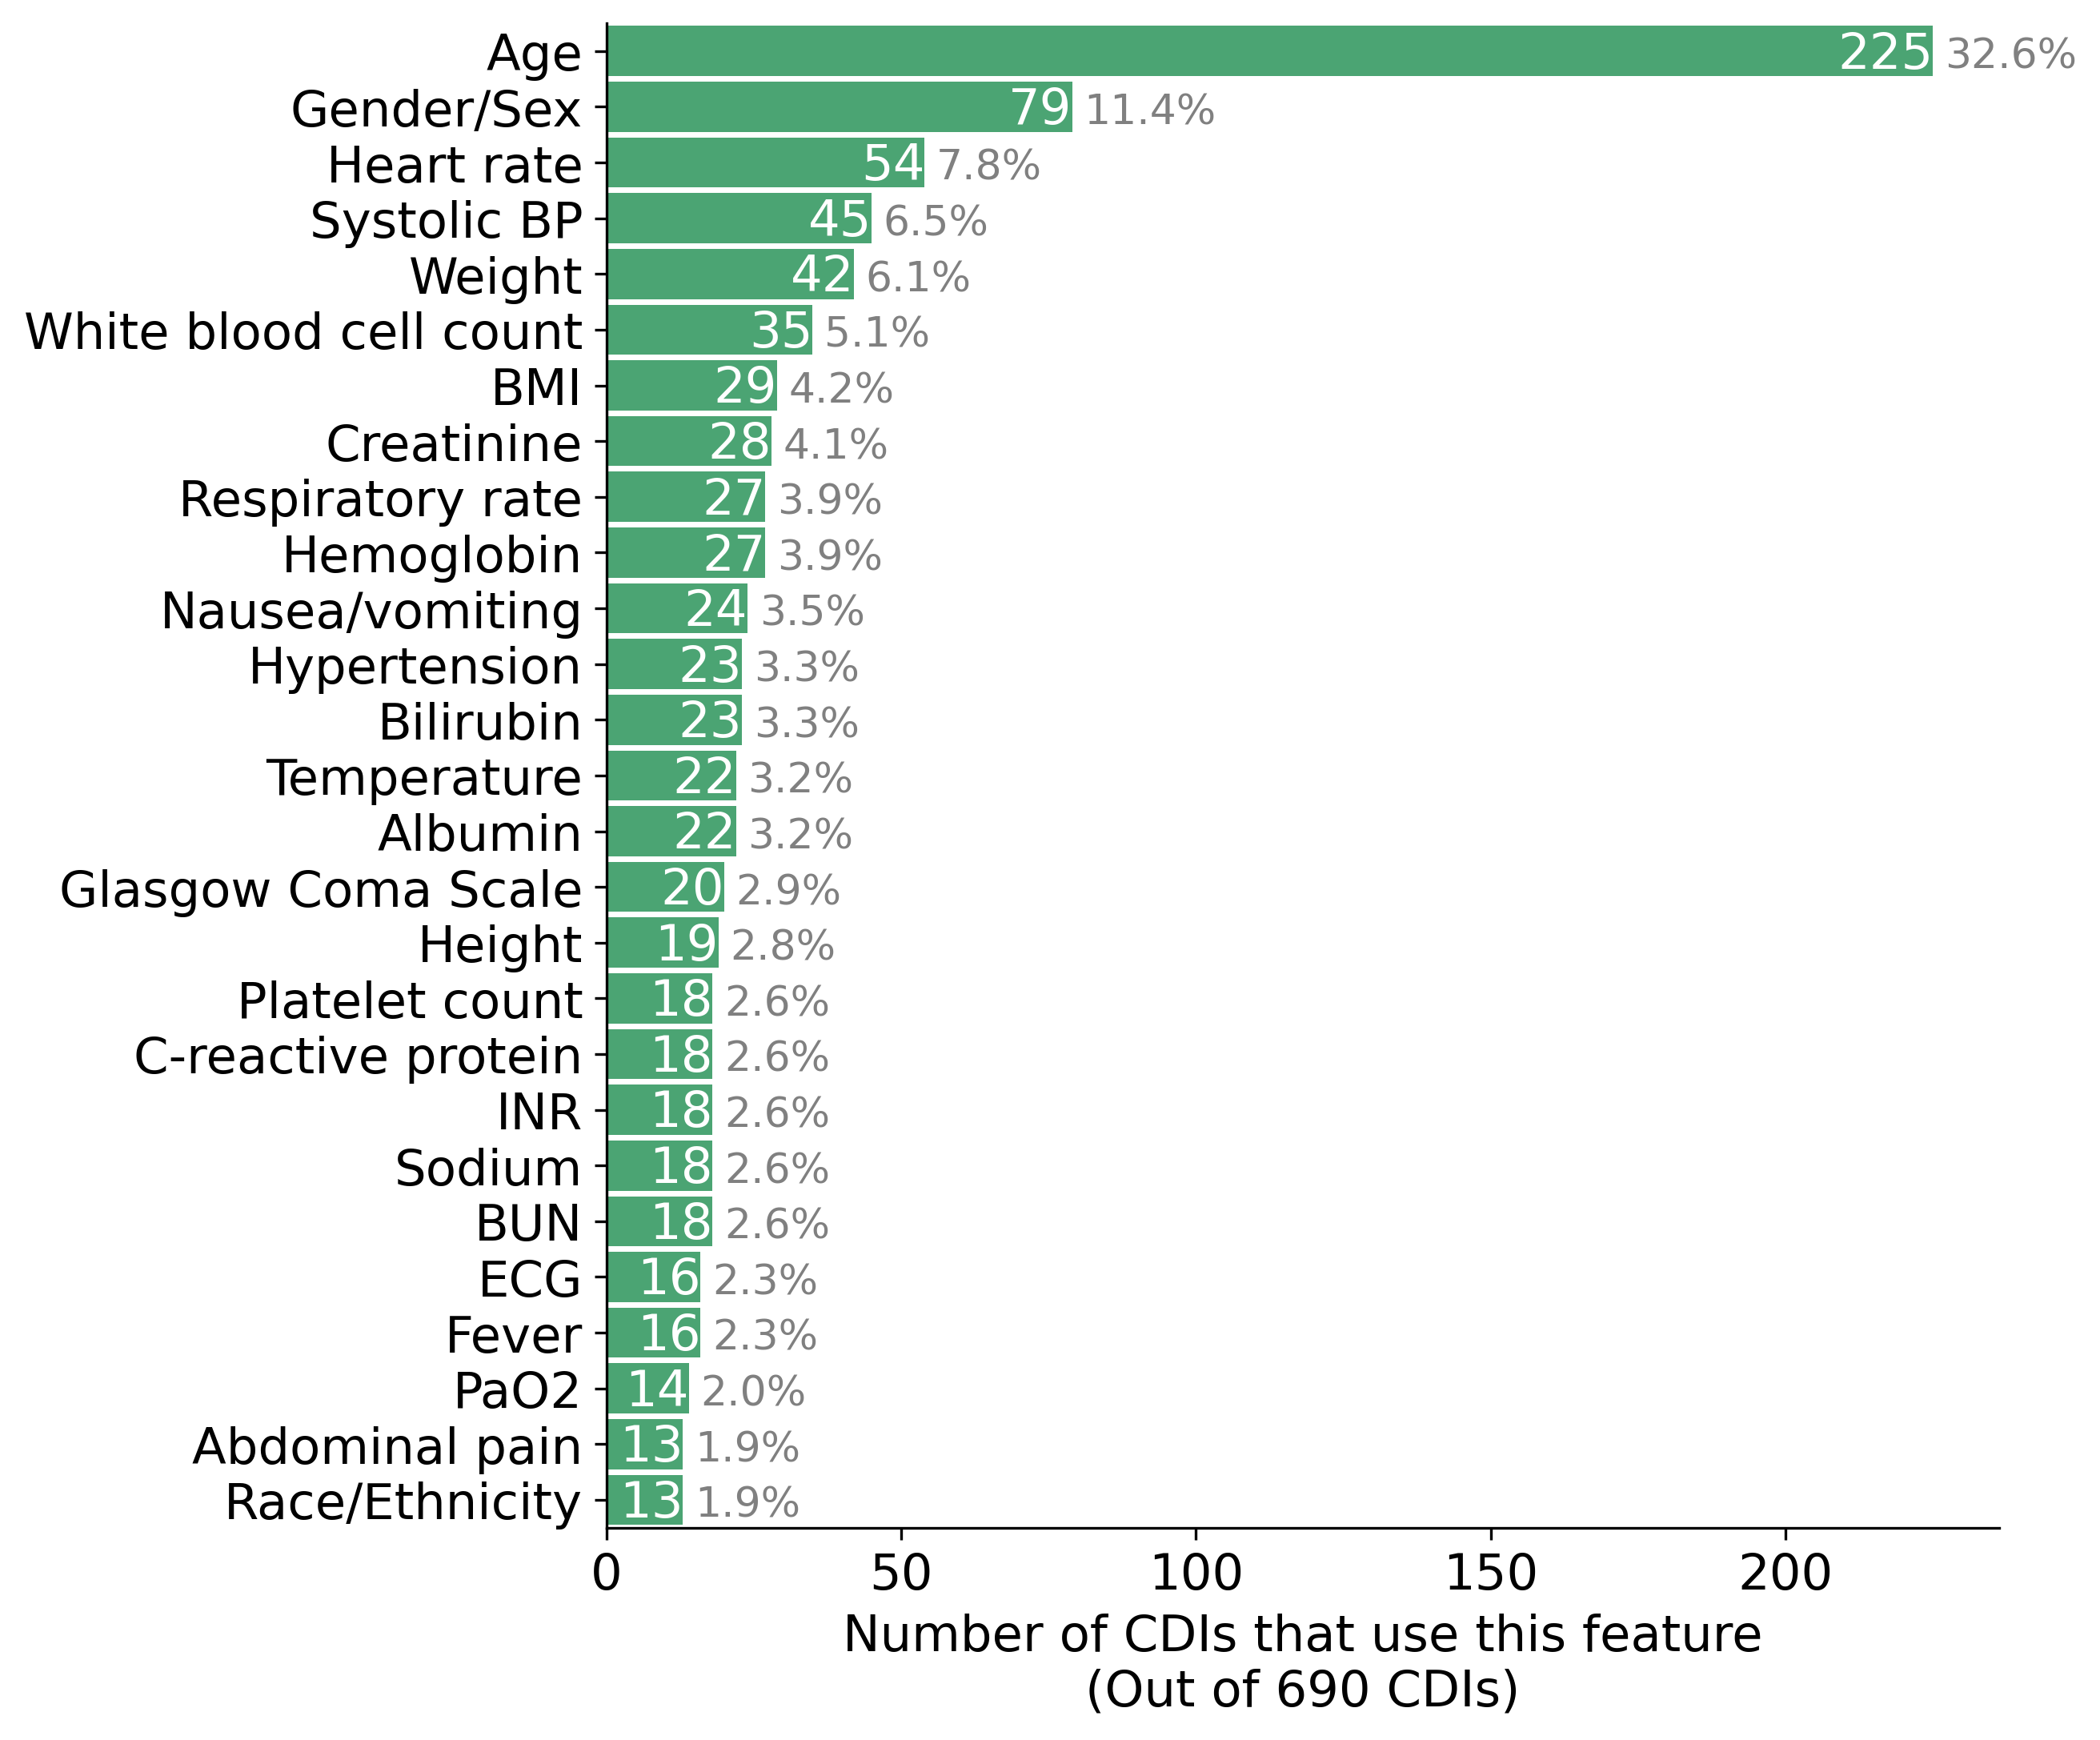

In [37]:
%load_ext autoreload
%autoreload 2


import dvu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

import mdcalc
import viz

# plt.style.use('default')
dvu.set_style()

df = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')

def get_feature_names_list(schema):
    if isinstance(schema, list):
        return [mdcalc.clean_feature_name(s['label_en']) if 'label_en' in s else 'unknown'
                for s in schema]
    else:
        return []

# these seem to be extra info in the calc, not actually a new feature
def remove_unknown(x):
    return [z for z in x if not z == 'unknown']

df['feature_names'] = df['input_schema'].apply(get_feature_names_list)
df['feature_names'] = df['feature_names'].apply(remove_unknown)
df['feature_names_unique'] = df['feature_names'].apply(
    lambda l: list(set([mdcalc.rename_feature_name(x) for x in l])))

# make plot
all_words = sum(df['feature_names_unique'], [])  # concatenate all list
all_words = pd.Series(all_words)
# all_words = all_words[~(all_words == 'unknown')] # not necessary, already handleed
counts = all_words.value_counts()
feat_names = pd.Series(counts.index)


counts.head(30)
plt.figure(figsize=(9, 7.5), dpi=300, facecolor='w')
N = 27
# plt.grid()
ax = sns.barplot(y=feat_names[:N].apply(lambda x: x[:39]),
                 x=counts.values[:N], orient='h', color='mediumseagreen', width=0.9)
# ax.bar_label(ax.containers[0], fontsize='small')
# bar_label inside of bar
# ax.bar_label(ax.containers[0], fontsize='small', labels=[str(x) + f' ({100 * x/df.shape[0]:.1f}%)' for x in counts.values[:N]])
# add text to each bar
# texts = [str(x) + f' ({100 * x/df.shape[0]:.1f}%)' for x in counts.values[:N]]
texts = [str(x) for x in counts.values[:N]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts[i], (p.get_width(), p.get_y() + 0.75), ha='right', color='white')
texts_perc = [f'{100 * x/df.shape[0]:.1f}%' for x in counts.values[:N]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts_perc[i], (p.get_width() + 2, p.get_y() + 0.75), ha='left', color='gray', fontsize='small')
plt.xlabel(f'Number of CDIs that use this feature\n(Out of {df.shape[0]} CDIs)')
plt.tight_layout()
viz.savefig('common_features')

**Look at the renaming**

In [2]:
feats_print = sorted(set(sum(df['feature_names'], [])))
df_print = pd.DataFrame(feats_print, columns=['Original feature'])
df_print['Chandan rename'] = df_print['Original feature'].apply(mdcalc.rename_feature_name)
idxs_same = df_print['Chandan rename'] == df_print['Original feature']
df_print['Chandan rename'][idxs_same] = ''
df_print.to_csv('../data/renaming/features.csv', index=False)

### Feature counts

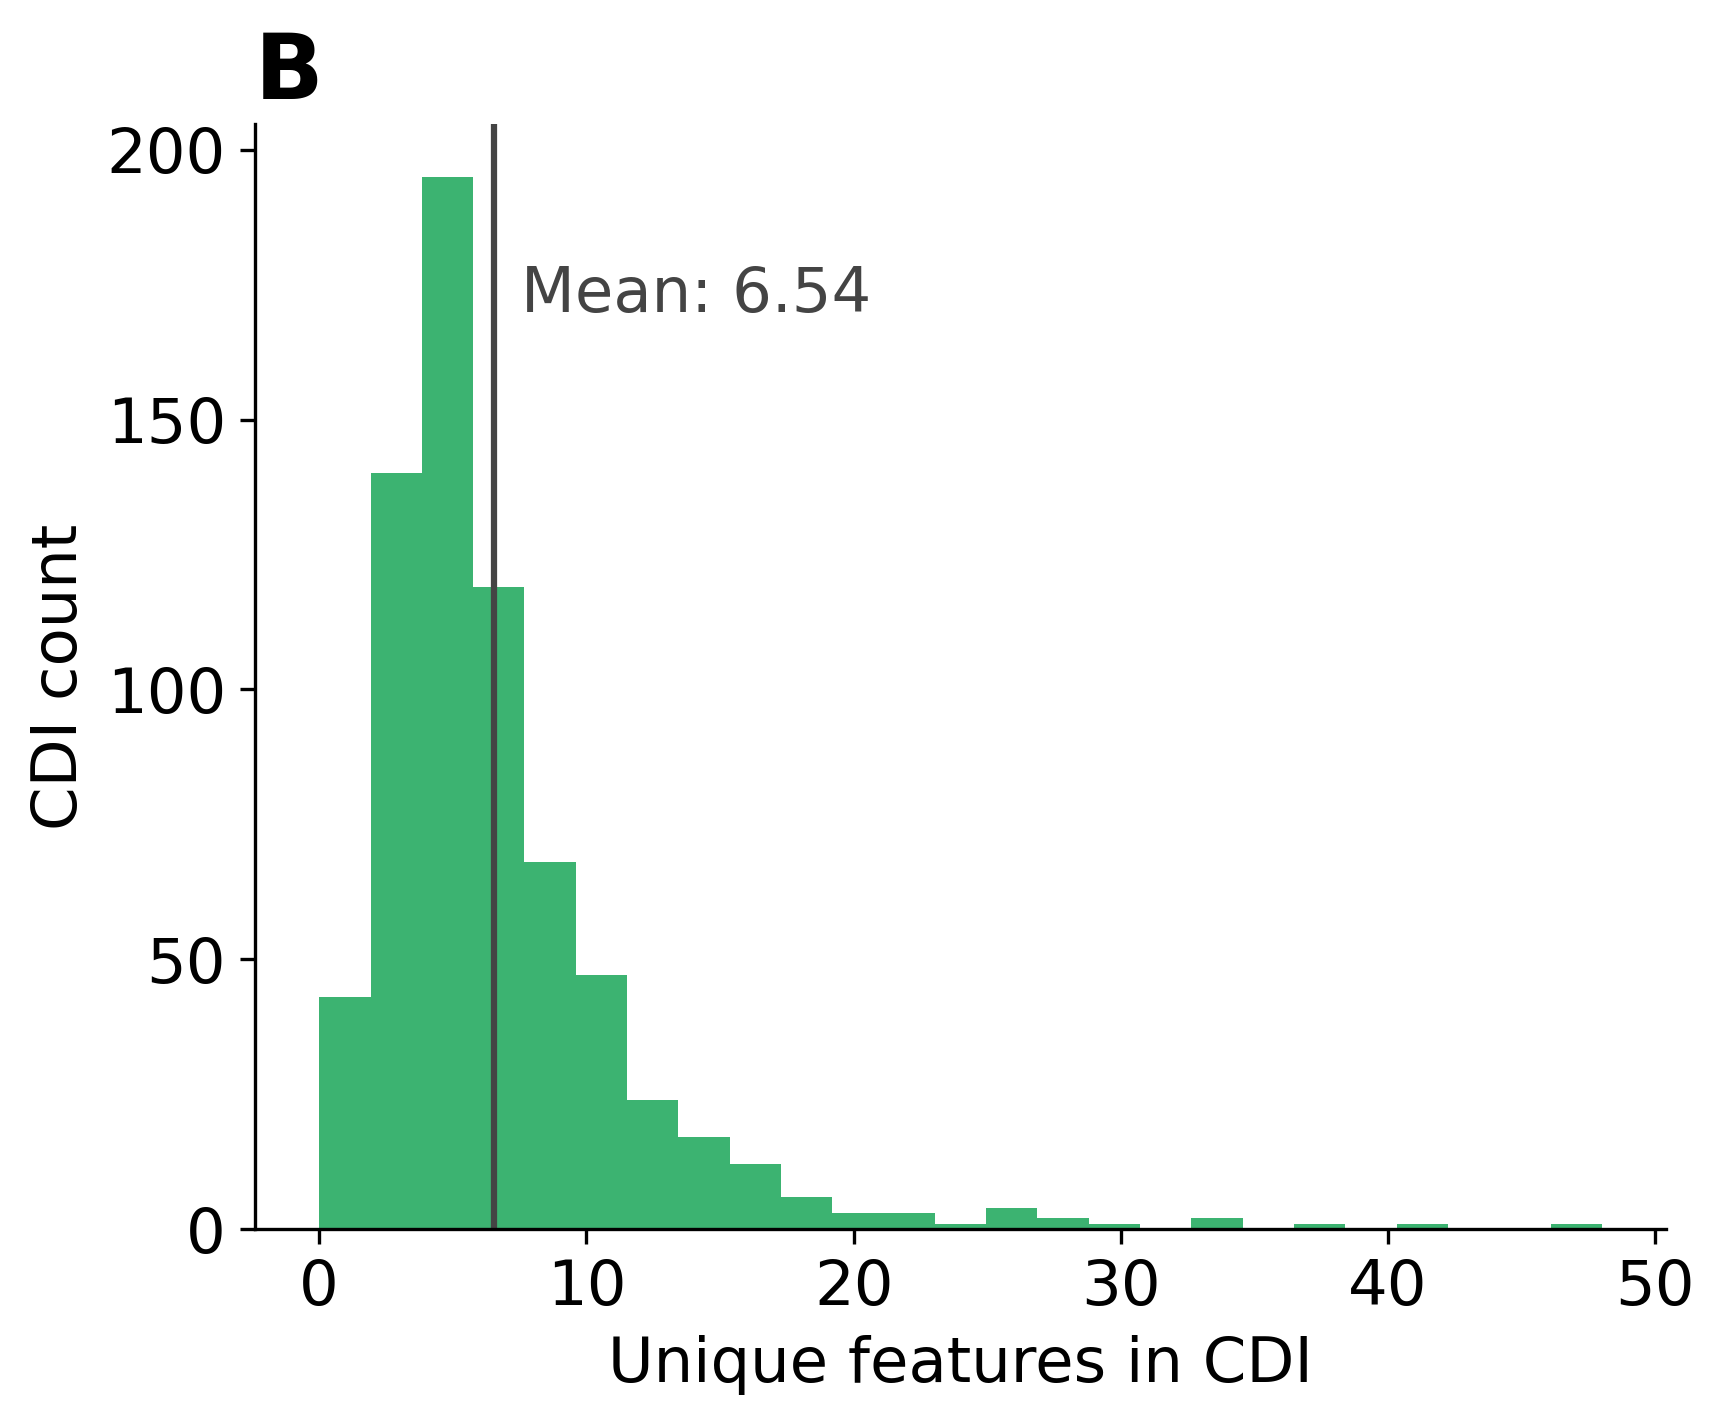

In [3]:
# df['num_splits'] = df['feature_names'].apply(len)
df['num_features_unique'] = df['feature_names_unique'].apply(len)

plt.figure(dpi=300, facecolor='w', figsize=(6, 5))
# plt.hist(df['num_splits'], label='Splits in CDI', bins=25)
avg = np.mean(df['num_features_unique'])
plt.axvline(x=avg, ls='-', color='#444')
plt.text(s=f'Mean: {avg:0.2f}', x=avg + 1, y=170, color='#444')
plt.hist(df['num_features_unique'], label='Unique features in CDI', bins=25, color='mediumseagreen') #, alpha=0.8)
plt.xlabel('Unique features in CDI')
# plt.ylabel(f'Count of CDIs\n(out of {df.shape[0]} CDIs)')
plt.ylabel('CDI count')
plt.title('B', loc='left', fontsize='x-large', fontweight='bold')
plt.tight_layout()

# plt.legend()
viz.savefig('num_rules_hist')
# plt.show()

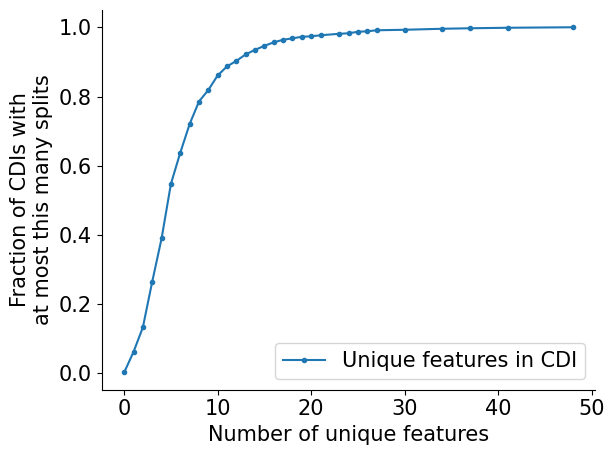

In [4]:
# vals, counts = np.unique(df['num_splits'], return_counts=True)
# plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Splits in CDI')
# val_90 = (np.cumsum(counts) / np.sum(counts)) >= 0.9

# plt.show()
vals, counts = np.unique(df['num_features_unique'], return_counts=True)
plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Unique features in CDI')

plt.xlabel('Number of unique features')
plt.ylabel('Fraction of CDIs with\nat most this many splits')
plt.legend()
viz.savefig('num_rules_cdf')
plt.show()

# Feature analysis

only keeping 309 CDIs out of 690


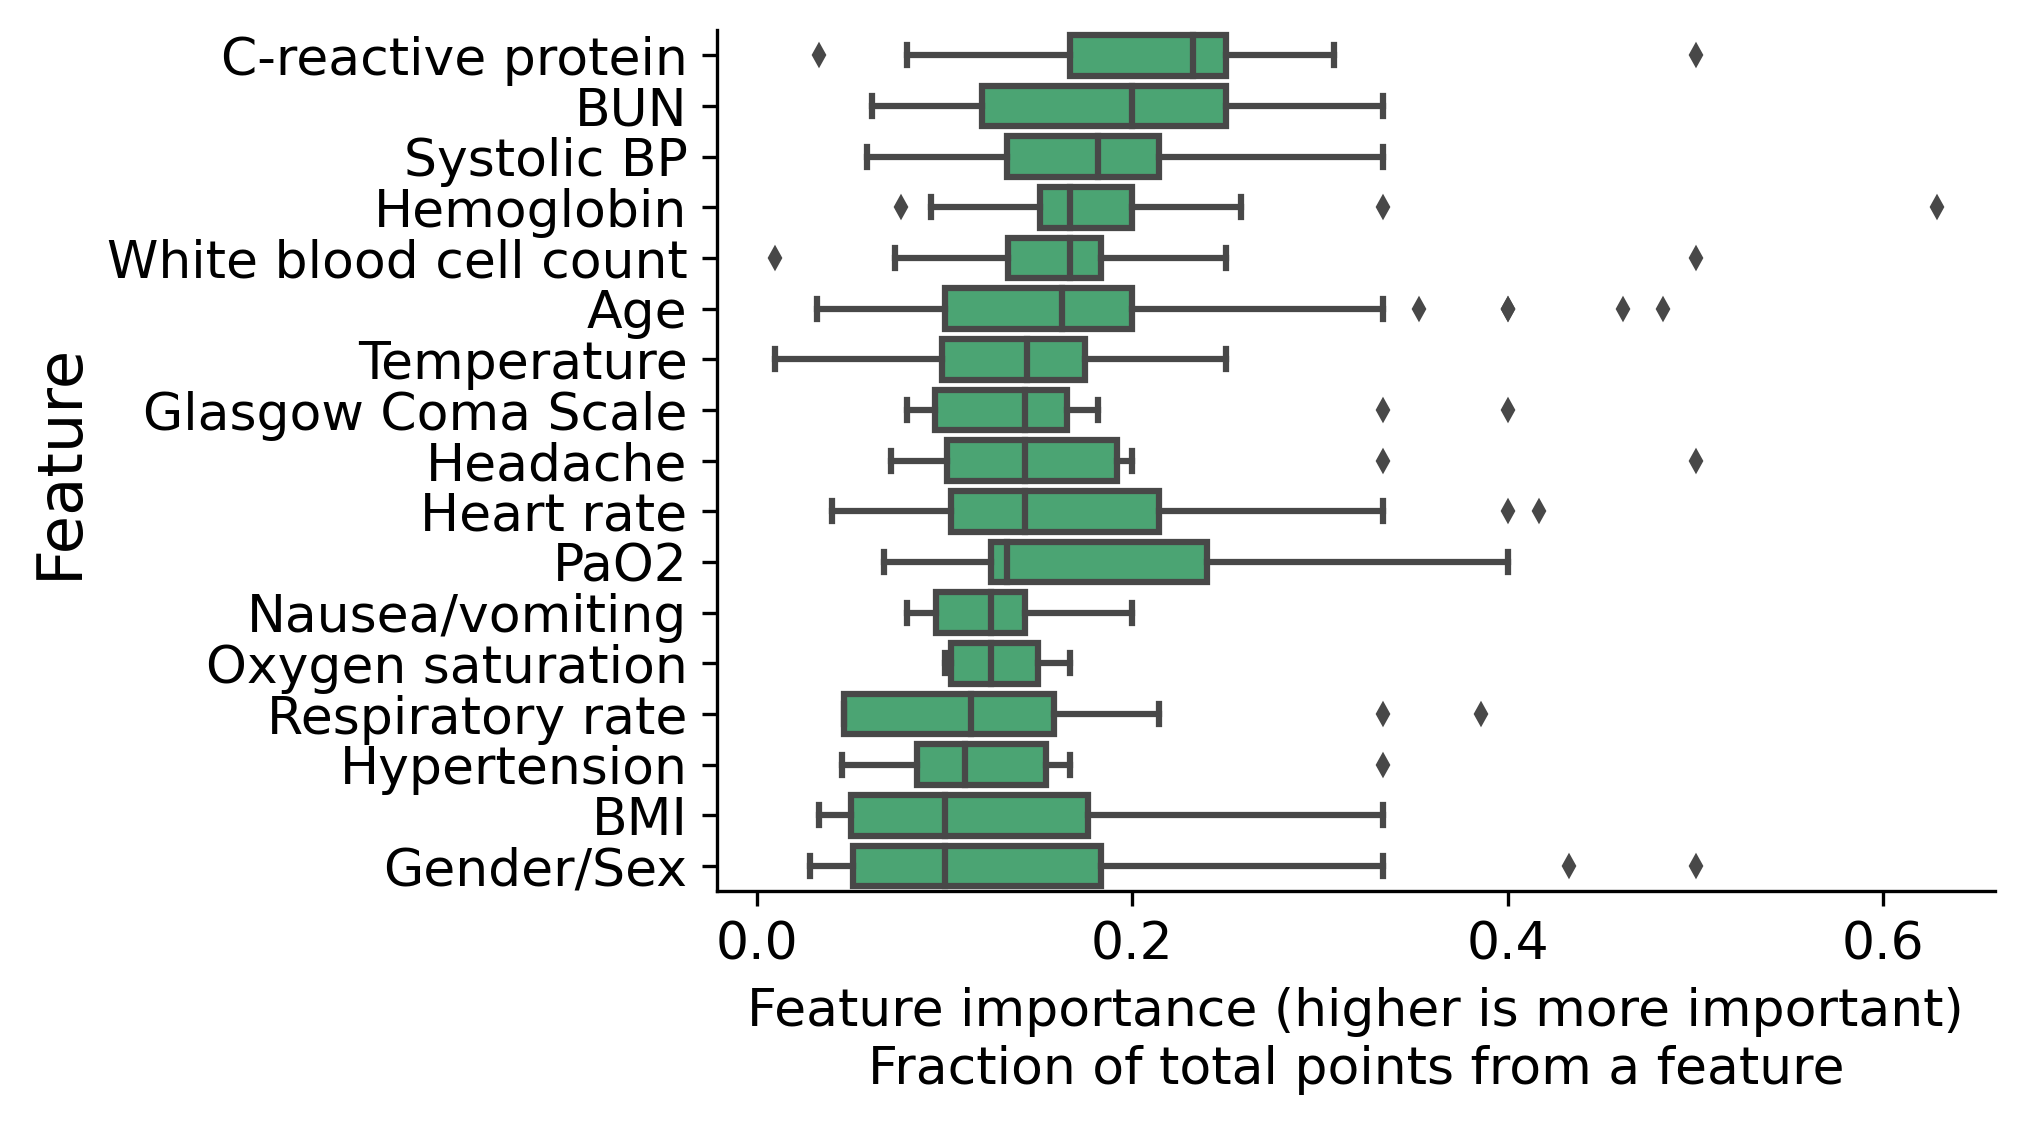

In [39]:
# get scores for each feature
df["feature_names_with_vals"] = df["input_schema"].apply(
    mdcalc.get_feature_names_with_vals_list
)

# only keep scoring-only CDIs
feature_names_with_vals = df["feature_names_with_vals"][
    df["feature_names_with_vals"].apply(len) > 0
]
print("only keeping", feature_names_with_vals.shape[0], "CDIs out of", df.shape[0])

# get score_dict
score_tuples = sorted(sum(feature_names_with_vals, []), key=lambda x: x[0])
ks = sorted(set([score_tuple[0] for score_tuple in score_tuples]))
score_dict = defaultdict(list)
for key, score in score_tuples:
    score_dict[key].append(score)

# filter list
scores_list = [
    (k, v)
    for (k, v) in score_dict.items()
    if len(v) >= 9
    # or k == 'Race/Ethnicity'
]
# scores_list = sorted(score_dict_filt, key=lambda x: len(x[1]), reverse=True)

# format into df
feat_name_vec = sum([[k] * len(v) for (k, v) in scores_list], [])
score_vec = sum([v for (k, v) in scores_list], [])
df_box = pd.DataFrame.from_dict({"feat_name": feat_name_vec, "score": score_vec})
medians = df_box.groupby(["feat_name"])["score"].median().sort_values(ascending=False)

# plot
plt.figure(dpi=300, figsize=(7, 4))
# place grid in background behind other elements
sns.boxplot(
    x="score",
    y="feat_name",
    data=df_box,
    color="mediumseagreen",
    order=medians.index,
    fliersize=3.1,
    whis=1.5,

    # change color of fliers
    # flierprops=dict(alpha=1, marker='o', color='#EEE'),
)
plt.ylabel("Feature")
plt.yticks(fontsize="small")
plt.xticks(fontsize="small")
plt.xlabel(
    "Feature importance (higher is more important)\nFraction of total points from a feature",
    fontsize="small",
)
# plt.grid(axis="x")
plt.tight_layout()
viz.savefig("scoring_cdi_boxplot")

In [40]:
# example debugging schema
# x = d[d.url == 'cha2ds2-vasc-score-atrial-fibrillation-stroke-risk'].iloc[0]
# x = df.iloc[0]
# schema = x['input_schema']
# schema
# for s in schema:
#     options = s['options']
#     print(s['name'], clean.clean_feature_name(s['label_en']), [opt['value'] for opt in options])

In [45]:
display(df[df["feature_names_with_vals"].apply(len) == 2].iloc[3][['url_full', 'input_schema']])

url_full        https://www.mdcalc.com/calc/3837/modified-fish...
input_schema    [{'type': 'radio', 'name': 'crp', 'default': N...
Name: 377, dtype: object

In [41]:
df[df["feature_names_with_vals"].apply(len) == 2]

,id,full_title_en,medium_description_en,slug,cme_enabled,type,url_full,favorite_id,calc_type,dosing,...,created_at,updated_at,feature_names,refs,ref_original,ref_href,ref_text,ref_year,feature_names_unique,feature_names_with_vals
662,2045,Urine Anion Gap,<p>Detects urine acidosis for evaluation of no...,urine-anion-gap,False,c,https://www.mdcalc.com/calc/2045/urine-anion-gap,10226.0,,False,...,NaN,NaN,"[Wheals, Pruritus]",{'Original/Primary Reference': [{'href': 'http...,[{'href': 'https://www.ncbi.nlm.nih.gov/pubmed...,https://www.ncbi.nlm.nih.gov/pubmed/18445192,"Młynek A, Zalewska-janowska A, Martus P, Staub...",2008.0,"[Wheals, Pruritus]","[(Wheals, 0.5), (Pruritus, 0.5)]"
248,3311,Glasgow Prognostic Score (GPS) for Cancer Outc...,<p>Provides cancer prognosis based on serum bi...,glasgow-prognostic-score-gps-cancer-outcomes,False,c,https://www.mdcalc.com/calc/3311/glasgow-progn...,3311.0,,False,...,NaN,NaN,"[CRP, Albumin]",{'Original/Primary Reference': [{'href': 'http...,[{'href': 'https://www.ncbi.nlm.nih.gov/pmc/ar...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,"Forrest LM, McMillan DC, McArdle CS, Angerson ...",2003.0,"[Albumin, C-reactive protein]","[(C-reactive protein, 0.25), (Albumin, 0.25)]"
490,3385,Prevention and Incidence of Asthma and Mite Al...,<p>Determines risk of asthma for school age ch...,prevention-incidence-asthma-mite-allergy-piama...,False,c,https://www.mdcalc.com/calc/3385/prevention-in...,3313.0,calculator,False,...,NaN,NaN,"[CRP, White blood cell count]","{'Validation': [{'text': ' Proctor MJ, et al. ...","[{'text': 'Kasymjanova G, MacDonald N, Agulnik...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,"Kasymjanova G, MacDonald N, Agulnik JS, et al....",2010.0,"[White blood cell count, C-reactive protein]","[(C-reactive protein, 0.5), (White blood cell ..."
377,3837,Modified Fisher Grading Scale for Subarachnoid...,<p>States severity of SAH based on amount and ...,modified-fisher-grading-scale-subarachnoid-hem...,True,c,https://www.mdcalc.com/calc/3837/modified-fish...,3312.0,calculator,False,...,NaN,NaN,"[CRP, Albumin]","{'Validation': [{'text': 'Nozoe T, Iguchi T, E...","[{'text': 'Proctor MJ, Morrison DS, Talwar D, ...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,"Proctor MJ, Morrison DS, Talwar D, Balmer SM, ...",2011.0,"[Albumin, C-reactive protein]","[(C-reactive protein, 0.25), (Albumin, 0.25)]"
141,3903,Cardiac Anesthesia Risk Evaluation Score (CARE),<p>Predicts mortality and morbidity after card...,cardiac-anesthesia-risk-evaluation-score-care,True,c,https://www.mdcalc.com/calc/3903/cardiac-anest...,3903.0,calculator,False,...,NaN,NaN,"[Patient status, Emergency: surgery as soon as...",{'Validation': [{'text': 'Ouattara A et al. Pr...,[{'text': 'Dupuis JY et al. The Cardiac Anesth...,https://www.ncbi.nlm.nih.gov/pubmed/11176081,Dupuis JY et al. The Cardiac Anesthesia Risk E...,2001.0,[Emergency: surgery as soon as diagnosis is ma...,"[(Patient status, 0.6666666666666666), (Emerge..."
73,3929,Asymptomatic Myeloma Prognosis,<p>Predicts risk of progression of asymptomati...,asymptomatic-myeloma-prognosis,True,c,https://www.mdcalc.com/calc/3929/asymptomatic-...,3929.0,calculator,False,...,NaN,NaN,"[Bone marrow plasmacytosis, Serum monoclonal p...","{'Validation': [{'text': 'Kastritis E, Terpos ...","[{'text': 'Kyle RA, Remstein ED, Therneau TM, ...",http://www.ncbi.nlm.nih.gov/pubmed/17582068,"Kyle RA, Remstein ED, Therneau TM, Dispenzieri...",2007.0,"[Serum monoclonal protein, g/dL, Bone marrow p...","[(Bone marrow plasmacytosis, 0.5), (Serum mono..."
67,4046,Antivenom Dosing Algorithm,"<p>Doses antivenom (CroFab only, not Anavip) f...",antivenom-dosing-algorithm,True,c,https://www.mdcalc.com/calc/4046/antivenom-dos...,4046.0,calculator,True,...,NaN,NaN,"[Are there signs of envenomation?, Are there i...","{'Validation': [], 'Outcomes': [], 'Validation...","[{'text': 'Lavonas EJ, Ruha AM, Banner W, et a...",https://www.ncbi.nlm.nih.gov/pubmed/21291549,"Lavonas EJ, Ruha AM, Bann

In [48]:
# display full
with pd.option_context("display.max_colwidth", 1000):
    display(df[df["feature_names_with_vals"].apply(len) == 2][['url_full', 'input_schema']])

,url_full,input_schema
662,https://www.mdcalc.com/calc/2045/urine-anion-gap,"[{'type': 'radio', 'label_en': 'Wheals', 'default': 0, 'conditionality': '', 'show_points': True, 'tips_en': '', 'optional': False, 'options': [{'label': 'None', 'value': 0}, {'label': 'Mild (<20 wheals/24 hrs)', 'value': 1}, {'label': 'Moderate (20-50 wheals/24 hrs)', 'value': 2}, {'label': 'Intense (>50 wheals/24 hrs or large confluent areas of wheals)', 'value': 3}], 'name': 'wheals'}, {'type': 'radio', 'label_en': 'Pruritus', 'default': 0, 'conditionality': '', 'show_points': True, 'tips_en': '', 'optional': False, 'options': [{'label': 'None', 'value': 0}, {'label': 'Mild (present but not annoying or troublesome)', 'value': 1}, {'label': 'Moderate (troublesome but does not interfere with normal daily activity or sleep)', 'value': 2}, {'label': ' Intense (severe, interferes with normal daily activity or sleep)', 'value': 3}], 'name': 'pruritus'}]"
248,https://www.mdcalc.com/calc/3311/glasgow-prognostic-score-gps-cancer-outcomes,"[{'type': 'radio', 'label_en': 'CRP', 'default': None, 'conditionality': '', 'show_points': False, 'tips_en': '', 'optional': False, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 1}, {'label': 'CRP >10 mg/L', 'value': 2}], 'name': 'crp'}, {'type': 'radio', 'label_en': 'Albumin', 'default': None, 'conditionality': '', 'show_points': False, 'tips_en': '', 'optional': False, 'options': [{'label': 'Albumin <3.5 g/dL (35 g/L)', 'value': 1}, {'label': 'Albumin ≥3.5 g/dL (35 g/L)', 'value': 2}], 'name': 'alb'}]"
490,https://www.mdcalc.com/calc/3385/prevention-incidence-asthma-mite-allergy-piama-risk-score,"[{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 0}, {'label': 'CRP >10 mg/L', 'value': 1}], 'mdcalc_info_concept': None}, {'type': 'radio', 'name': 'wbc', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'White blood cell count', 'option_fhir_rules': None, 'options': [{'label': 'WBC ≤ 11 x 10⁹/L', 'value': 0}, {'label': 'WBC > 11 x 10⁹/L', 'value': 1}], 'mdcalc_info_concept': None}]"
377,https://www.mdcalc.com/calc/3837/modified-fisher-grading-scale-subarachnoid-hemorrhage-sah,"[{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 1}, {'label': 'CRP >10 mg/L', 'value': 2}], 'mdcalc_info_concept': None}, {'type': 'radio', 'name': 'alb', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'label_en': 'Albumin', 'option_fhir_rules': None, 'options': [{'label': 'Albumin <3.5 g/dL (35 g/L)', 'value': 1}, {'label': 'Albumin ≥3.5 g/dL (35 g/L)', 'value': 2}], 'mdcalc_info_concept': None}]"
141,https://www.mdcalc.com/calc/3903/cardiac-anesthesia-risk-evaluation-score-care,"[{'type': 'radio', 'label_en': 'Patient status', 'name': 'care', 'default': None, 'show_points': True, 'optional': False, 'conditionality': '', 'tips_en': '', 'options': [{'label': 'Stable cardiac disease, no other medical problems, undergoing noncomplex surgery', 'value': 1}, {'label': 'Stable cardiac disease, one or more controlled medical problems, undergoing noncomplex surgery', 'value': 2}, {'label': 'Any uncontrolled medical problem OR undergoing complex surgery', 'value': 3}, {'label': 'Any uncontrolled medical problem AND undergoing complex surgery', 'value': 4}, {'label': 'Chronic or advanced cardiac disease undergoing cardiac surgery as a last hope to save or improve life', 'value': 5}]}, {'type': 'toggle', 'name': 'e', 'conditionality': 'care >= 3', 'optional': True, 'default': None, 'label_en': 'Emergency: surgery as soon as diagnosis is made and operating room is available', 'show_points': True, 'tips_en': '', 'opt